In [1]:
import os 
import glob
import numpy as np
import rasterio as rio
import pandas as pd
import json
import pyproj
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.mask import raster_geometry_mask
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform
import geopandas as gpd
from geocube.api.core import make_geocube
import rioxarray as rx

## Helper functions

In [2]:
# Multi-purpose binary mask (accepts .png, .jpg, or .tif mask files)

# Generate binary mask from multi-band .tif, .jpg, or .png file

def binary_mask_multi(mask_fp):
    '''This function turns a multi-band .tif, .jpg, or .png mask file into a single-band raster mask
    with unmasked pixels coded as 1s and masked pixels coded as 0s
    
    Inputs:
    mask_fp (str) : filepath to the mask .tif, .jpg, or .png file
    
    Returns:
    mask_arr_3d (np array) : 3-d numpy array of 0s and 1s'''

    if mask_fp[-3:]=='tif':
        with rio.open(mask_fp) as src:
            mask_arr = src.read()
            band_ct = mask_arr.shape[0]
    
            # get unique values for binary mask band (not necessarily 0 and 1)
            # binary mask band is the last band in the image
    
            mask_band = mask_arr[(band_ct-1)]
            mask_vals = np.unique(mask_band)
    
            # make binary mask 0s and 1s
            mask_arr_binary = mask_band*(1/(mask_vals[1]))
            mask_arr_binary[mask_arr_binary != 1] = 0
    
            mask_arr_3d = mask_arr_binary.reshape(1,mask_arr.shape[1],mask_arr.shape[2])
            return mask_arr_3d
            
    elif mask_fp[-3:]=='png':
        mask_arr = plt.imread(mask)
        band_ct = mask_arr.shape[2]
        mask_band = mask_arr[:,:,band_ct-1]
        mask_vals = np.unique(mask_band)
        mask_arr_binary = mask_band*(1/(mask_vals[-1]))
        mask_arr_binary[mask_arr_binary != 1] = 0
        mask_arr_3d = mask_arr_binary.reshape(1,mask_arr.shape[0],mask_arr.shape[1])
        return mask_arr_3d
        
    elif mask_fp[-3:]=='jpg':
        mask_arr = plt.imread(mask_fp)
        band_ct = mask_arr.shape[2]
        mask_band = mask_arr[:,:,-band_ct]
        mask_vals = np.unique(mask_band)
        mask_arr_binary = mask_band*(1/(mask_vals[-1]))
        mask_arr_binary[mask_arr_binary != 1] = 0
        mask_arr_3d = mask_arr_binary.reshape(1,mask_arr.shape[0],mask_arr.shape[1])
        return mask_arr_3d

    else:
        print ("mask file type is not supported. Supported file types are: .tif .png .jpg")


In [3]:
# Mask function

def mask_img(img_fp, mask_fp, output_dir):
    """
    This function masks a multispectral UAS image using a binary mask file
    The mask file must have the same dimensions and CRS as the UAV image.
    
    Inputs:
    img_fp (str) : filepath to the UAV image to be masked (.tif) 
    
    mask_fp (str) : filepath to the mask file (.tif)
    
    output_dir (str) : directory to store the masked .tif image (e.g. 'kathleen/Desktop/')
    
    Returns:
    
    Filepath to the masked .tif file. 
    The masked .tif is saved to the output_dir and has the same dimensions and CRS as the original UAV image. 
    All masked pixels will have a value of 0 for all bands. Unmasked pixels will retain original band values. 
    """ 
    
    mask_arr = binary_mask_multi(mask_fp)
    
    with rio.open(img_fp) as src:
        img_arr = src.read()
        masked_img_arr = mask_arr * img_arr
        
        kwargs = src.meta
        band_ct = masked_img_arr.shape[0]
        kwargs.update(dtype=rio.float32, count=band_ct)

        masked_img_fp = output_dir+ 'masked_'+ str(os.path.basename(img_fp))
        
        with rio.open(masked_img_fp,
                      'w', **kwargs) as dst:
            for b in range(masked_img_arr.shape[0]):
                dst.write_band(b+1, masked_img_arr[b].astype(rio.float32))
        
        return masked_img_fp
        
        #checks
        #print(masked_img_arr.shape)
        #plot.show(masked_img_arr[(band_ct-1)])
    

## Mask the multispectral UAS orthomosaic  

In [26]:
# Paths to multispectral UAS orthomosaic and corresponding mask file. 
### Modify these filepaths to match your file structure ###

ortho = '/Users/kathleenkanaley/Desktop/M600/imgs/2023/chardonnay_20230705.tif' 
ortho_data = rio.open(ortho)

mask = '/Users/kathleenkanaley/Desktop/M600/masks/chardonnay_20230705_mask_modified.tif'
mask_data = rio.open(mask)


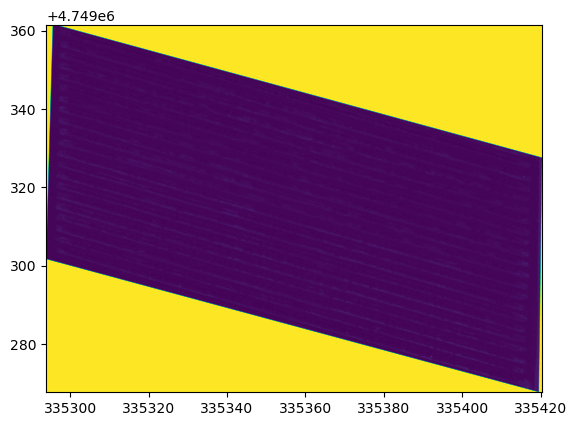

<Axes: >

In [28]:
# visualize orthomosaic
plot.show(ortho_data)

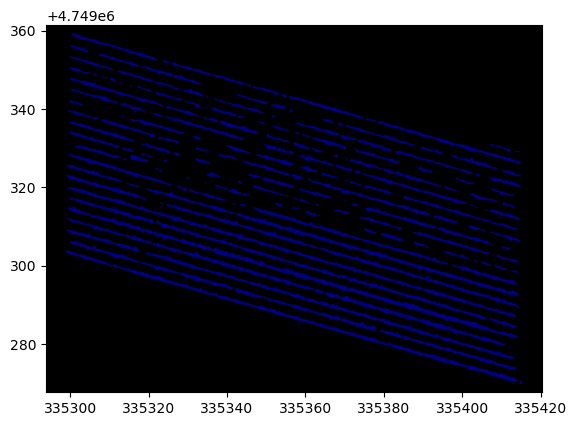

<Axes: >

In [29]:
# visualize mask
plot.show(mask_data)

In [8]:
# Mask the orthomosaic with the corresponding mask .tif file

### modify path to match your file structure ###

output_dir = '/Users/kathleenkanaley/Desktop/' 
mask_filepath = mask_img(ortho, mask, output_dir)

## Use a metadata file to extract reflectance data for each experimental unit

In [9]:
# The metadata file in this example is a GEOJSON containing vineyard panel coordinates
# The experimental unit is one grapevine panel (one panel = 3 adjacent vines)

# Metadata file with panel geometries
### Modify this path to match your file structure ###

metadata_path = '/Users/kathleenkanaley/Desktop/M600/geojsons/chard_panels_2m.geojson'

# Read the metadata file as a geodataframe
gdf = gpd.read_file(metadata_path)
gdf.head()

,row,panel,geometry
0,1,1,"POLYGON ((335412.589 4749269.964, 335405.213 4..."
1,1,2,"POLYGON ((335405.213 4749272.093, 335398.293 4..."
2,1,3,"POLYGON ((335398.293 4749273.992, 335391.263 4..."
3,1,4,"POLYGON ((335391.263 4749275.998, 335384.071 4..."
4,1,5,"POLYGON ((335384.071 4749277.965, 335377.230 4..."


In [10]:
# Reset index
gdf['index'] = gdf.index
gdf

,row,panel,geometry,index
0,1,1,"POLYGON ((335412.589 4749269.964, 335405.213 4...",0
1,1,2,"POLYGON ((335405.213 4749272.093, 335398.293 4...",1
2,1,3,"POLYGON ((335398.293 4749273.992, 335391.263 4...",2
3,1,4,"POLYGON ((335391.263 4749275.998, 335384.071 4...",3
4,1,5,"POLYGON ((335384.071 4749277.965, 335377.230 4...",4
...,...,...,...,...
315,20,5,"POLYGON ((335383.919 4749329.971, 335377.209 4...",315
316,20,4,"POLYGON ((335391.111 4749327.992, 335383.919 4...",316
317,20,3,"POLYGON ((335398.266 4749326.043, 335391.111 4...",317
318,20,2,"POLYGON ((335405.679 4749323.952, 335398.266 4...",318


In [11]:
img_data = rx.open_rasterio(mask_filepath)
img_data

<xarray.DataArray (band: 10, y: 4451, x: 6013)>
[267638630 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 3.353e+05 3.353e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 4.749e+06 4.749e+06 ... 4.749e+06 4.749e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
out_grid = make_geocube(
    vector_data=gdf,
    measurements=['row','panel','index'], ## replace 'row' and 'panel' with your own unique identifiers ##
    like=img_data, # ensure the data are on the same grid
)

In [13]:
out_grid

<xarray.Dataset>
Dimensions:      (y: 4451, x: 6013)
Coordinates:
  * y            (y) float64 4.749e+06 4.749e+06 ... 4.749e+06 4.749e+06
  * x            (x) float64 3.353e+05 3.353e+05 ... 3.354e+05 3.354e+05
    spatial_ref  int64 0
Data variables:
    row          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    panel        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [14]:
#This section is specific to the MicaSense Dual Camera System - modify according to your camera settings
cblue_444 = img_data[0]
blue_475 = img_data[1]
green_531 = img_data[2]
green_560 = img_data[3]
red_650 = img_data[4]
red_668 = img_data[5]
rededge_705 = img_data[6]
rededge_717 = img_data[7]
rededge_740 = img_data[8]
nir_842 = img_data[9]
    
    
band_dict = {'cblue_444':cblue_444, 'blue_475':blue_475, 'green_531':green_531,'green_560':green_560,
                 'red_650':red_650,'red_668':red_668, 'rededge_705':rededge_705,'rededge_717':rededge_717,
                 'rededge_740':rededge_740, 'nir_842':nir_842}

In [15]:
# merge the dfs together

for key, b in band_dict.items():
    out_grid[key] = (b.dims, b.values, b.attrs, b.encoding)

out_grid


<xarray.Dataset>
Dimensions:      (y: 4451, x: 6013)
Coordinates:
  * y            (y) float64 4.749e+06 4.749e+06 ... 4.749e+06 4.749e+06
  * x            (x) float64 3.353e+05 3.353e+05 ... 3.354e+05 3.354e+05
    spatial_ref  int64 0
Data variables: (12/13)
    row          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    panel        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    cblue_444    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    blue_475     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    green_531    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    red_650      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    red_668      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rededge_705  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rededge_717  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rededge_740  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nir_842      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [16]:
# Change zeros to NAN
out_grid_nans= out_grid.where(out_grid > 0)

In [17]:
out_grid_nans

<xarray.Dataset>
Dimensions:      (y: 4451, x: 6013)
Coordinates:
  * y            (y) float64 4.749e+06 4.749e+06 ... 4.749e+06 4.749e+06
  * x            (x) float64 3.353e+05 3.353e+05 ... 3.354e+05 3.354e+05
    spatial_ref  int64 0
Data variables: (12/13)
    row          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    panel        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    cblue_444    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    blue_475     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    green_531    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    red_650      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    red_668      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    rededge_705  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    rededge_717  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    rededge_740  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nir_842      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [18]:
# Get a dataframe with per-pixel reflectance values
outgrid_df = out_grid_nans.to_dataframe()
outgrid_df.sort_values(by=['row', 'panel'], inplace=True) ## replace 'row' and 'panel' with your own unique identifiers ##
outgrid_df.reset_index(inplace=True)
outgrid_df.dropna(subset=['row',list(band_dict.keys())[0]], inplace=True) # remove pixels not associated with a row or with missing reflectance data
outgrid_df

,y,x,row,panel,index,cblue_444,blue_475,green_531,green_560,red_650,red_668,rededge_705,rededge_717,rededge_740,nir_842,spatial_ref
875,4.749274e+06,335405.644939,1.0,1.0,NaN,2192.0,2668.0,2909.0,3293.0,3464.0,3856.0,4969.0,4833.0,6721.0,5242.0,0
876,4.749274e+06,335405.665984,1.0,1.0,NaN,1700.0,1968.0,2241.0,2522.0,2532.0,2867.0,3822.0,3673.0,5610.0,4444.0,0
877,4.749274e+06,335405.687028,1.0,1.0,NaN,1351.0,1635.0,1906.0,2047.0,1875.0,2331.0,3120.0,3043.0,4811.0,4084.0,0
957,4.749274e+06,335405.623894,1.0,1.0,NaN,2754.0,3578.0,3754.0,3765.0,4153.0,5086.0,6097.0,6058.0,8191.0,6080.0,0
958,4.749274e+06,335405.644939,1.0,1.0,NaN,2031.0,2649.0,2873.0,2863.0,2953.0,3571.0,4606.0,4496.0,6463.0,4967.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10681764,4.749353e+06,335307.240389,20.0,16.0,304.0,1665.0,2097.0,4458.0,4699.0,2492.0,2179.0,7412.0,9079.0,15033.0,10147.0,0
10681765,4.749353e+06,335307.261434,20.0,16.0,304.0,1746.0,2173.0,5252.0,5480.0,2613.0,2162.0,8303.0,10487.0,17316.0,11666.0,0
10681766,4.749353e+06,335307.282479,20.0,16.0,304.0,1795.0,2196.0,4104.0,4375.0,2601.0,2409.0,7258.0,8615.0,14443.0,10220.0,0
10681767,4.749353e+06,335307.303523,20.0,16.0,304.0,1617.0,2017.0,2934.0,3267.0,2437.0,2463.0,5909.0,6795.0,11448.0,8521.0,0


## Optionally, calculate the average reflectance for each experimental unit

In [19]:
# Calculate the average reflectance for each experimental uit (in this case, experimental unit = one panel)
groupby_panel = out_grid_nans.drop("spatial_ref").groupby(out_grid_nans.index)

panel_means = groupby_panel.mean()
as_df = panel_means.to_dataframe()
as_df

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3003/1529542360.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  groupby_panel = out_grid_nans.drop("spatial_ref").groupby(out_grid_nans.index)


,row,panel,cblue_444,blue_475,green_531,green_560,red_650,red_668,rededge_705,rededge_717,rededge_740,nir_842
index,,,,,,,,,,,,
1.0,1.0,2.0,1150.862061,1381.955322,2677.831055,2898.593262,1460.679077,1357.146729,4615.215332,6425.585449,13408.184570,10288.532227
2.0,1.0,3.0,1258.523926,1513.064087,2942.795166,3192.715820,1572.435791,1442.641113,4894.730957,6702.217285,13745.581055,10399.905273
3.0,1.0,4.0,1098.868164,1333.534790,2749.924316,2959.677979,1405.124756,1254.370361,4649.160156,6439.465820,13288.543945,10114.103516
4.0,1.0,5.0,971.577454,1173.491821,2595.096924,2803.411133,1174.691284,998.000610,4370.830078,6288.892090,13542.286133,10373.329102
5.0,1.0,6.0,1133.529053,1361.924438,2843.747803,3047.646729,1403.144897,1246.226074,4730.671875,6633.349609,14023.192383,10668.145508
...,...,...,...,...,...,...,...,...,...,...,...,...
315.0,20.0,5.0,891.347473,1078.259399,2440.151367,2629.792725,1040.409180,857.492310,4031.788818,5796.201172,12428.772461,9230.266602
316.0,20.0,4.0,1018.512817,1230.872437,2225.280518,2357.026855,1224.613647,1156.794800,3665.932861,4946.219727,10042.372070,7528.987793
317.0,20.0,3.0,1253.556519,1510.924072,2558.275879,2707.895752,1510.621704,1484.444214,4174.200195,5513.231445,10755.629883,7902.995117


In [20]:
# Format the dataframe 
as_df.sort_values(by=['row', 'panel'], inplace=True) ## replace 'row' and 'panel' with your own unique identifiers ##
as_df.reset_index(inplace=True)
as_df

,index,row,panel,cblue_444,blue_475,green_531,green_560,red_650,red_668,rededge_705,rededge_717,rededge_740,nir_842
0,1.0,1.0,2.0,1150.862061,1381.955322,2677.831055,2898.593262,1460.679077,1357.146729,4615.215332,6425.585449,13408.184570,10288.532227
1,2.0,1.0,3.0,1258.523926,1513.064087,2942.795166,3192.715820,1572.435791,1442.641113,4894.730957,6702.217285,13745.581055,10399.905273
2,3.0,1.0,4.0,1098.868164,1333.534790,2749.924316,2959.677979,1405.124756,1254.370361,4649.160156,6439.465820,13288.543945,10114.103516
3,4.0,1.0,5.0,971.577454,1173.491821,2595.096924,2803.411133,1174.691284,998.000610,4370.830078,6288.892090,13542.286133,10373.329102
4,5.0,1.0,6.0,1133.529053,1361.924438,2843.747803,3047.646729,1403.144897,1246.226074,4730.671875,6633.349609,14023.192383,10668.145508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,308.0,20.0,12.0,1152.431030,1393.478882,2644.635986,2833.124023,1370.496948,1255.576782,4336.811035,5945.804199,12107.719727,8990.075195
315,307.0,20.0,13.0,926.978821,1125.310913,2553.598389,2756.646973,1092.194824,902.908447,4259.115234,6186.871582,13537.503906,10212.272461
316,306.0,20.0,14.0,1058.723022,1283.501099,2296.783203,2426.667480,1310.951904,1246.749756,3882.882324,5233.157715,10695.294922,8195.398438
317,305.0,20.0,15.0,1006.365601,1212.153931,2766.789062,3001.853516,1183.130127,979.218506,4575.244629,6612.600098,14336.063477,10808.636719


In [21]:
# More formatting
final_df = as_df.drop(['index'], axis=1)
final_df

,row,panel,cblue_444,blue_475,green_531,green_560,red_650,red_668,rededge_705,rededge_717,rededge_740,nir_842
0,1.0,2.0,1150.862061,1381.955322,2677.831055,2898.593262,1460.679077,1357.146729,4615.215332,6425.585449,13408.184570,10288.532227
1,1.0,3.0,1258.523926,1513.064087,2942.795166,3192.715820,1572.435791,1442.641113,4894.730957,6702.217285,13745.581055,10399.905273
2,1.0,4.0,1098.868164,1333.534790,2749.924316,2959.677979,1405.124756,1254.370361,4649.160156,6439.465820,13288.543945,10114.103516
3,1.0,5.0,971.577454,1173.491821,2595.096924,2803.411133,1174.691284,998.000610,4370.830078,6288.892090,13542.286133,10373.329102
4,1.0,6.0,1133.529053,1361.924438,2843.747803,3047.646729,1403.144897,1246.226074,4730.671875,6633.349609,14023.192383,10668.145508
...,...,...,...,...,...,...,...,...,...,...,...,...
314,20.0,12.0,1152.431030,1393.478882,2644.635986,2833.124023,1370.496948,1255.576782,4336.811035,5945.804199,12107.719727,8990.075195
315,20.0,13.0,926.978821,1125.310913,2553.598389,2756.646973,1092.194824,902.908447,4259.115234,6186.871582,13537.503906,10212.272461
316,20.0,14.0,1058.723022,1283.501099,2296.783203,2426.667480,1310.951904,1246.749756,3882.882324,5233.157715,10695.294922,8195.398438
317,20.0,15.0,1006.365601,1212.153931,2766.789062,3001.853516,1183.130127,979.218506,4575.244629,6612.600098,14336.063477,10808.636719


## Save the dataframe as a CSV

In [22]:
### Modify paths to match your file structure ###

## Per-pixel
# outgrid_df.to_csv('/Users/kathleenkanaley/Desktop/perpixel_chardonnay_20230705.csv',index=False)

## Per-panel (experimental unit)
#final_df.to_csv('/Users/kathleenkanaley/Desktop/perpanel_chardonnay_20230705.csv',index=False)